In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import os, sys
import dill as pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from sklearn.model_selection import train_test_split

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import SuperSpeculator
import popsed
popsed.set_matplotlib(style='JL', usetex=True, dpi=80, fontsize=16)
from popsed import prior

In [3]:
wave = np.load('./train_sed_NMF/nmf_seds/fsps.wavelength.npy')
name = 'NMF'
speculator = SuperSpeculator(
    speculators_dir=[f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}.emu_{i_bin}.pkl' for i_bin in range(0, 5)], 
    str_wbin=['.w1000_2000',
              '.w2000_3600', 
              '.w3600_5500', 
              '.w5500_7410', 
              '.w7410_60000'],
    wavelength=wave, 
    params_name=['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh', 
                 'fburst', 'tburst', 'logzsol',
                 'dust1', 'dust2', 
                 'dust_index', 'redshift', 'logm'],
    device='cuda', use_speclite=True)

gama_filters = ['sdss2010-{0}'.format(b) for b in 'ugriz']# + ['VIKING_{0}'.format(b) for b in ['Y']]
speculator._calc_transmission(gama_filters)

# gama_filters = ['sdss_{0}0'.format(b) for b in 'ugriz']# + ['VIKING_{0}'.format(b) for b in ['Y']]
# speculator._calc_transmission(gama_filters, filter_dir='./filters/gama/')

noise = None # 'gama'
noise_model_dir = './noise_model/gama_noise_model_mag_dr3_apmatch.npy'

In [4]:
X_data = np.load('./reference_catalog/GAMA/gama_clean_mag_dr3_apmatch.npy')[:, :5]
print('Total number of samples:', len(X_data))

Total number of samples: 110612


In [47]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [48]:
_prior_NDE = speculator.bounds.copy()

_prior_NDE[-2] = np.array([0., 1])
_prior_NDE[-1] = np.array([7.5, 13.])

In [49]:
nde_dir = './NDE/GAMA/NMF/nde_theta_NMF_CDF_DR3_noise/'
filelist = os.listdir(nde_dir)

# filelist = [file for file in filelist if 'nde_theta_best' in file]
# ind = [int(file.replace('nde_theta_best_loss_nsf_', '').strip('.pkl')) for file in filelist]

filelist = [file for file in filelist if 'nde_theta_last' in file]
ind = [int(file.replace('nde_theta_last_model_nsf_', '').strip('.pkl')) for file in filelist]

# filelist = np.array(filelist)[(np.array(ind) > 30)]
# filelist = ['nde_theta_best_loss_nsf_20.pkl',
#             'nde_theta_best_loss_nsf_31.pkl',
#             'nde_theta_best_loss_nsf_25.pkl', 
#             'nde_theta_best_loss_nsf_35.pkl']

In [50]:
len(filelist)

20

In [51]:
# This is slow
NDE_list = []
for file in filelist:
    try:
        NDE = pickle.load(open(os.path.join(nde_dir, file), 'rb'))
        del NDE.X
        del NDE.X_vali
        del NDE.batch_theta
#         NDE_list.append(NDE)
        if np.mean(NDE.vali_loss_history[-20:]) < 0.6:
            NDE_list.append(NDE)
#             pass
        else:
            print('Poor vali loss for', file)
#             print('Remove', file)
    except Exception as e:
        print(file, e)
        continue

Poor vali loss for nde_theta_last_model_nsf_12.pkl
Poor vali loss for nde_theta_last_model_nsf_1.pkl
Poor vali loss for nde_theta_last_model_nsf_8.pkl
Poor vali loss for nde_theta_last_model_nsf_14.pkl
Poor vali loss for nde_theta_last_model_nsf_6.pkl


In [10]:
### score for each model is vali_loss

In [52]:
vali_loss = np.array([np.mean(NDE.vali_loss_history[-20:]) for NDE in NDE_list])
vali_loss

array([0.20780092, 0.26818978, 0.31889811, 0.50665608, 0.18730777,
       0.35780304, 0.14846589, 0.18722657, 0.23556068, 0.32168728,
       0.16534771, 0.36102035, 0.27412464, 0.14276162, 0.13724034])

In [53]:
score = np.min(vali_loss) / vali_loss
score

array([0.66044146, 0.51172846, 0.43035796, 0.27087475, 0.73269965,
       0.38356393, 0.92438973, 0.73301743, 0.58261141, 0.42662657,
       0.83001054, 0.38014572, 0.50064941, 0.96132519, 1.        ])

In [66]:
vali_loss[np.argsort(vali_loss)]

array([0.13724034, 0.14276162, 0.14846589, 0.16534771, 0.18722657,
       0.18730777, 0.20780092, 0.23556068, 0.26818978, 0.27412464,
       0.31889811, 0.32168728, 0.35780304, 0.36102035, 0.50665608])

In [69]:
np.array(NDE_list)[np.argsort(vali_loss)][:5]

array([<popsed.nde.WassersteinNeuralDensityEstimator object at 0x153ea2f8ea10>,
      dtype=object)

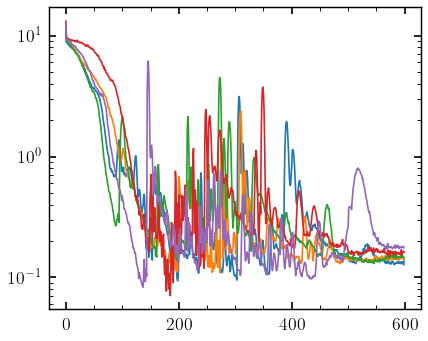

In [70]:
[plt.plot(NDE.train_loss_history) for NDE in np.array(NDE_list)[np.argsort(vali_loss)][:5]]
plt.yscale('log')

In [55]:
torch.cuda.empty_cache()

### Show each NDE

In [56]:
from popsed.nde import transform_nmf_params, inverse_transform_nmf_params

from popsed.nde import inverse_transform_nmf_params_given_mass

In [75]:
_samples_unt = []
_samples = []
for NDE in [NDE_list[i] for i in np.argsort(vali_loss)[:5]]:
    _samp = inverse_transform_nmf_params(NDE.sample(3000), _prior_NDE).cpu().detach().numpy()
    
    _samples_unt.append(_samp)
    _samples.append(np.hstack([_samp[:, -1:], 
                   prior.FlatDirichletPrior(4).transform(_samp[:, :3]), 
                   _samp[:, 3:-1]]))
_samples_unt = np.dstack(_samples_unt)
_samples = np.dstack(_samples)

In [72]:
import corner

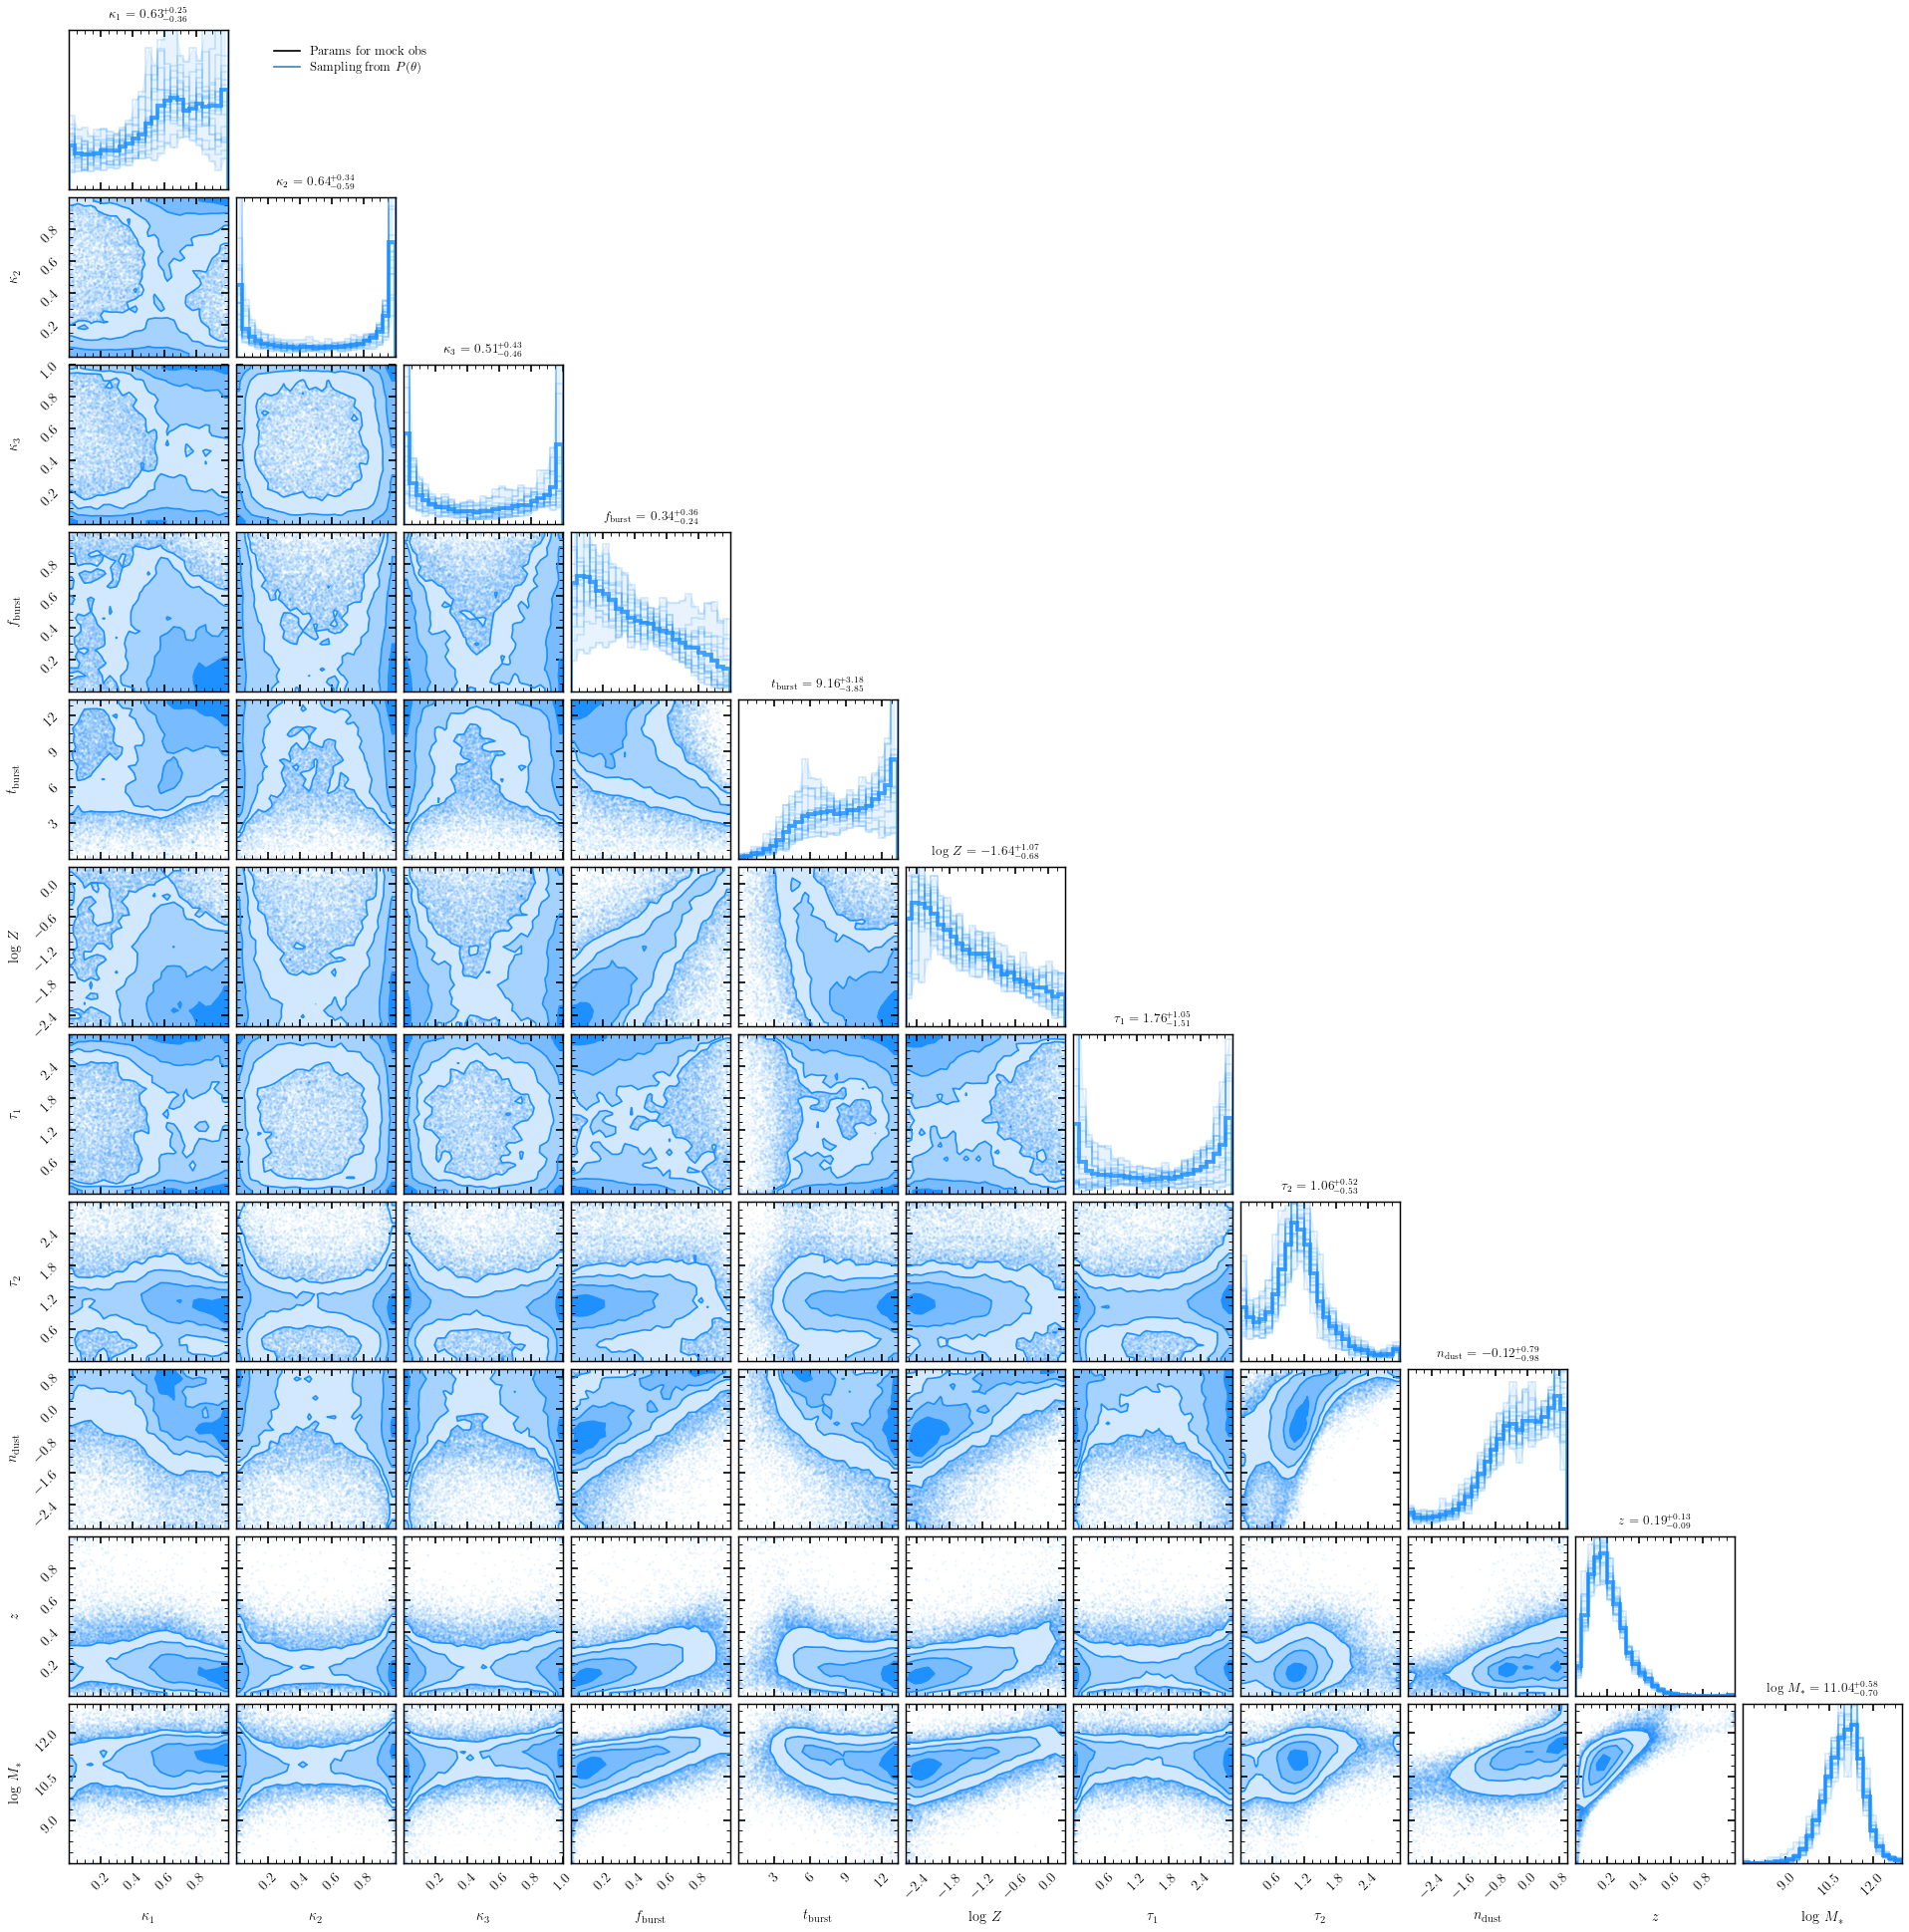

In [58]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Sampling from $P(\theta)$')

labels = [
    r'$\kappa_{1}$',
    r'$\kappa_{2}$',
    r'$\kappa_{3}$',
    r'$f_{\mathrm{burst}}$',
    r'$t_{\mathrm{burst}}$',
    r'$\log\,Z$',
    r'$\tau_1$',
    r'$\tau_2$',
    r'$n_{\mathrm{dust}}$',
    r'$z$',
    r'$\log\,M_*$',
    ]

figure = corner.corner(_samples_unt, 
                  labels=labels, bins=25,
                  color='dodgerblue',
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

ax = figure.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [73]:
z_mass_met = np.load('./reference_catalog/GAMA/gama_clean_z_mass_dr3_apmatch.npy')

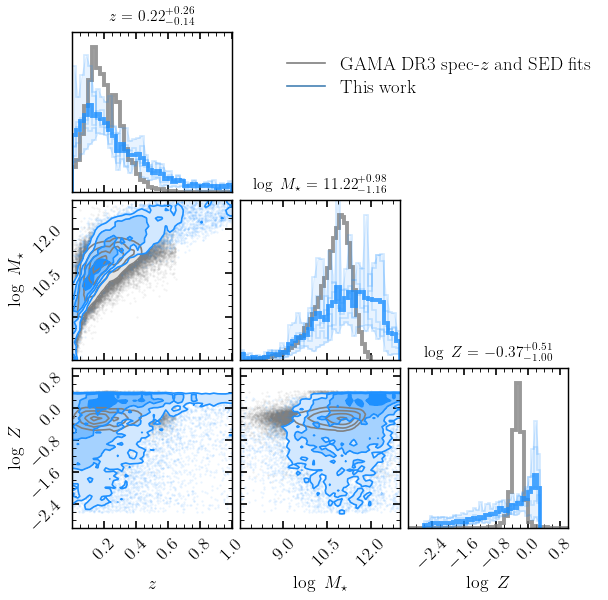

In [76]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='gray', label='GAMA DR3 spec-$z$ and SED fits')
b_line = mlines.Line2D([], [], color='steelblue', label=r'This work')

figure = corner.corner(z_mass_met, 
#                        fig=figure,
                  labels=['$z$', '$\log\ M_\star$', '$\log\ Z$'], bins=40,
                  color='gray', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                       range=[[0, 1], [8, 12], [-3, 1]], 
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

figure = corner.corner(np.hstack([_samples_unt[:, -2:-1], _samples_unt[:, -1:], _samples_unt[:, 5:6]]), 
                       fig=figure,
                  labels=['$z$', '$\log\ M_\star$', '$\log\ Z$'], bins=40,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

ax = figure.get_axes()[2]
ax.legend(handles=[k_line, b_line], fontsize=17, bbox_to_anchor=(0., 1.0, 1.3, .0))

# plt.suptitle('GAMA DR3 aperture-matched photometry, SDSS $ugriz$', y=1.06)

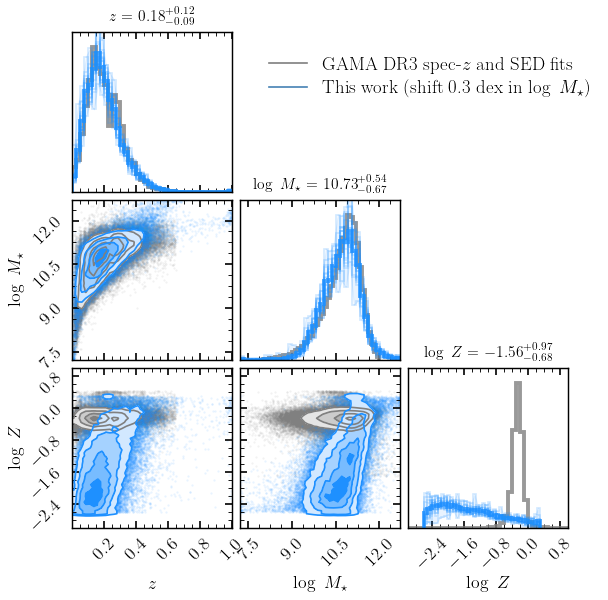

In [45]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='gray', label='GAMA DR3 spec-$z$ and SED fits')
b_line = mlines.Line2D([], [], color='steelblue', label=r'This work (shift 0.3 dex in $\log\ M_\star$)')

figure = corner.corner(z_mass_met, 
#                        fig=figure,
                  labels=['$z$', '$\log\ M_\star$', '$\log\ Z$'], bins=40,
                  color='gray', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                       range=[[0, 1], [8, 12], [-3, 1]], 
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

figure = corner.corner(np.hstack([_samples_unt[:, -2:-1], _samples_unt[:, -1:] - 0.3, _samples_unt[:, 5:6]]), 
                       fig=figure,
                  labels=['$z$', '$\log\ M_\star$', '$\log\ Z$'], bins=40,
                  color='dodgerblue', # quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.5, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 14}, 
                        hist_kwargs={'density': True}, plot_datapoints=True)

ax = figure.get_axes()[2]
ax.legend(handles=[k_line, b_line], fontsize=17, bbox_to_anchor=(0., 1.0, 1.3, .0))

# plt.suptitle('GAMA DR3 aperture-matched photometry, SDSS $ugriz$', y=1.06)

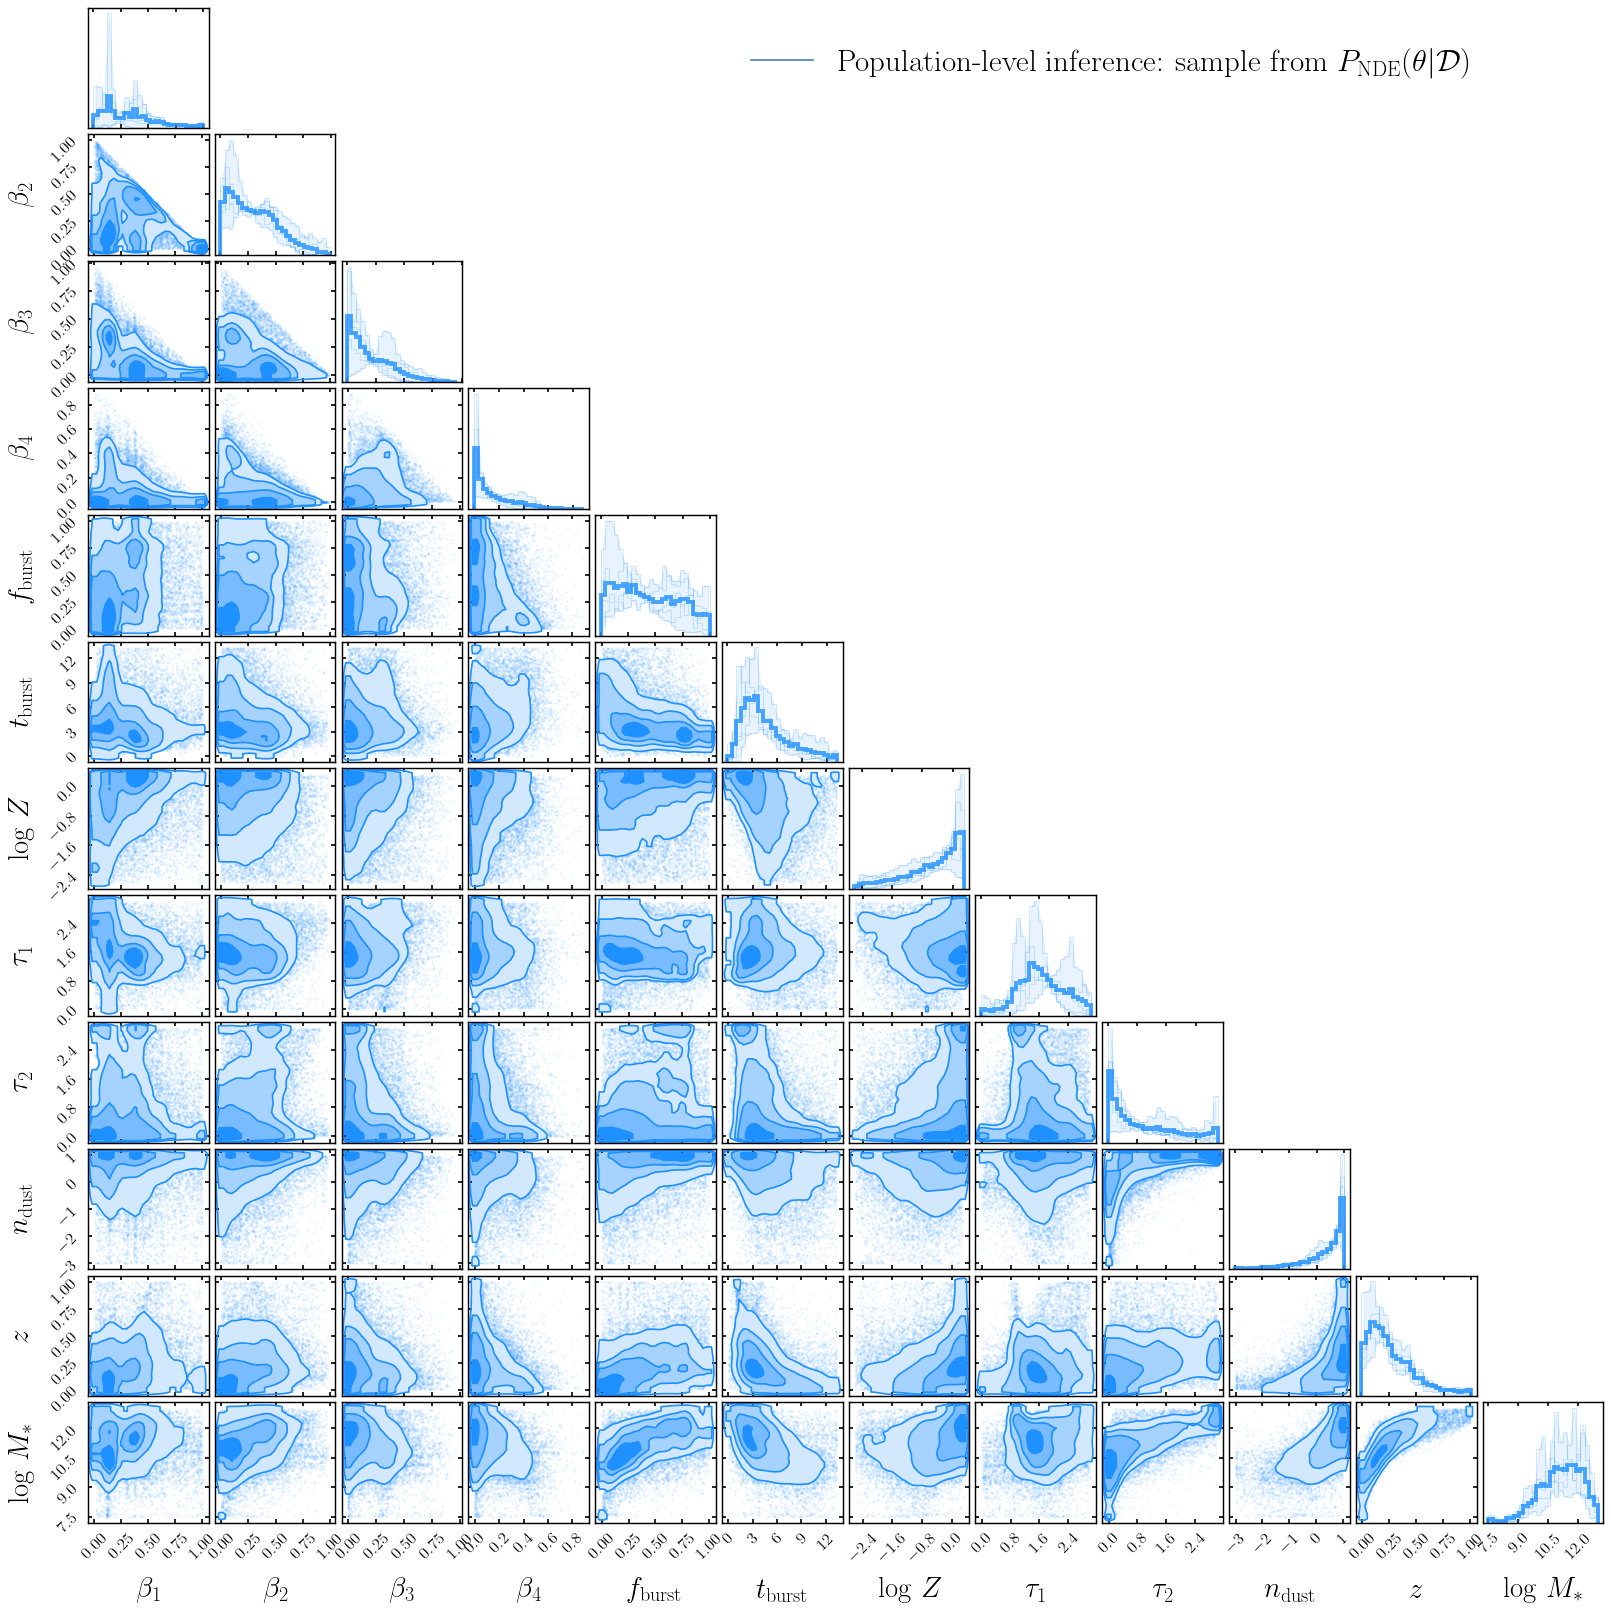

In [77]:
import matplotlib.lines as mlines
# k_line = mlines.Line2D([], [], color='k', label='Parameters for mock observation')
b_line = mlines.Line2D([], [], color='steelblue', 
                       label=r'Population-level inference: sample from $P_{\mathrm{NDE}}(\theta|\mathcal{D})$')

labels = [
    r'$\beta_{1}$',
    r'$\beta_{2}$',
    r'$\beta_{3}$',
    r'$\beta_{4}$',
    r'$f_{\mathrm{burst}}$',
    r'$t_{\mathrm{burst}}$',
    r'$\log\,Z$',
    r'$\tau_1$',
    r'$\tau_2$',
    r'$n_{\mathrm{dust}}$',
    r'$z$',
    r'$\log\,M_*$',
    ]

figure, axes = plt.subplots(12, 12, figsize=(20, 20))

y_truth_trans = np.hstack([_samples[:, 1:], # params taken by emulator, including redshift (for t_age)
                           _samples[:, 0:1], # stellar mass
                    ])
figure = corner.corner(
    y_truth_trans,
    fig=figure,
    color='dodgerblue',
    labels=labels,
#     range=[[0, 1], [0, 1], [0., 1], [0, 1], [-0.02, 1.02], [0.5, 13], 
#            [-2.5, 0.3], [0, 3], [0, 1.6], [-2, 1], [0, 0.06], [8, 12]],
    bins=25,
    smooth=1.0,
    fill_contours=True,
    show_titles=False,
    title_kwargs={'fontsize': 18},
    label_kwargs={'fontsize': 26},
    labelpad=0.15,
    hist_kwargs={'density': True, 'lw': 1},
#     plot_datapoints=False
    )

for ax in figure.get_axes():
    ax.tick_params(labelsize=15, length=4)
    ax.minorticks_off()

ax = figure.get_axes()[10]
ax.legend(handles=[b_line],  # k_line, 
          fontsize=28, 
          bbox_to_anchor=(0., 1.0, 1.3, .0))

In [43]:
_spl = _samples_unt.swapaxes(0, 1).reshape(11, -1).T

In [23]:
# del _samples
# import gc
# gc.collect()

0 5000
>30 0


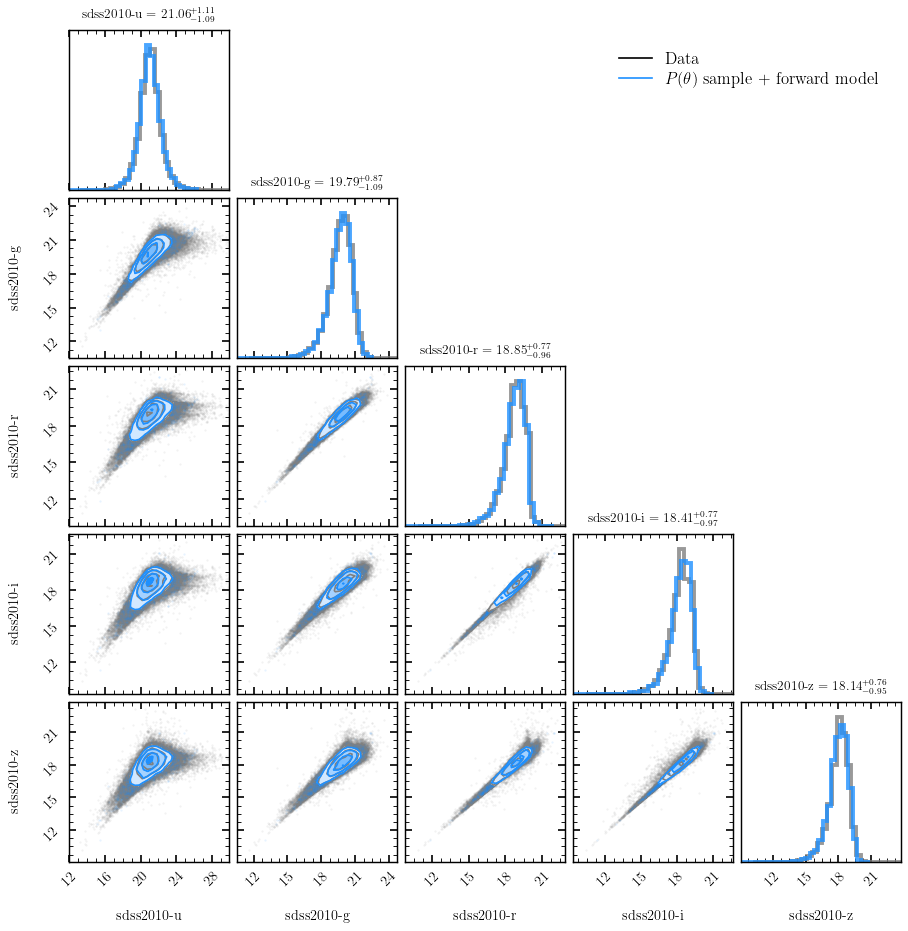

In [63]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
#r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = [filt.replace('_', '\_') for filt in gama_filters]

figure = corner.corner(X_data, 
                       color='gray', labels=labels, bins=30,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.4, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

_spl = _samples_unt.swapaxes(0, 1).reshape(11, -1).T
_spl = torch.Tensor(_spl[np.random.randint(0, len(_spl), 5000)]).to('cuda')
# _z = torch.Tensor(np.random.choice(NDE.external_redshift_data, len(_spl))[
#     :, None]).to(NDE.device)
# _spl = torch.hstack([_spl[:, :-1], _z, _spl[:, -1:]])


mags = speculator._predict_mag_with_mass_redshift(_spl,
                                                  filterset=gama_filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
print('>30', np.any(mags > 30, axis=1).sum())
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
mags = mags[~np.any(mags > 30, axis=1)]
nf_plot = corner.corner(mags, 
                  fig=figure, labels=labels, bins=30,
                        #range=[[14, 25]] * 5,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.4, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [52]:
sedflow_sample_unt = np.hstack([prior.FlatDirichletPrior(4).untransform(sedflow_sample[:, :4]), 
                                sedflow_sample[:, 4:]])

In [53]:
sedflow_sample_unt.shape

(10000, 11)

In [54]:
# sedflow_mag = np.load('./nsa_sedflow/nsa_sedflow.posterior_combined.nanomaggies.npy')
# mags = -2.5 * np.log10(sedflow_mag) + 22.5

0 5000
>30 0
0 5000
>30 0
38 9959
>30 0


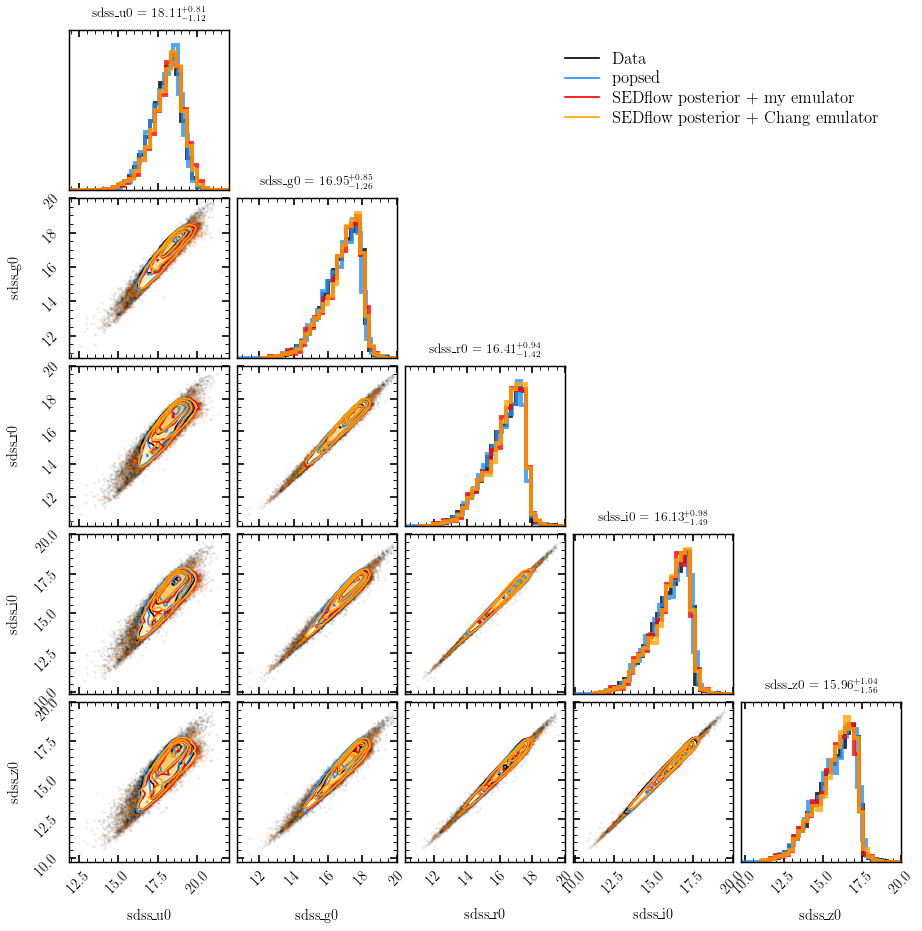

In [55]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
r_line = mlines.Line2D([], [], color='r', label='SEDflow posterior + my emulator')
o_line = mlines.Line2D([], [], color='orange', label='SEDflow posterior + Chang emulator')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'popsed')

labels = [filt.replace('_', '\_') for filt in filters]

figure = corner.corner(X_data.cpu().detach().numpy(), 
                       color='k', labels=labels, bins=30,
                       range=[[12, 22], [12, 20], [11, 20], [11, 20], [11, 20]],
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.4, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

mags = speculator._predict_mag_with_mass_redshift(_spl,
                                                  filterset=filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
print('>30', np.any(mags > 30, axis=1).sum())
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
mags = mags[~np.any(mags > 30, axis=1)]
nf_plot = corner.corner(mags, 
                  fig=figure, labels=labels, bins=30,
                        #range=[[14, 25]] * 5,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.4, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})


_spl = sedflow_sample_unt
_spl = torch.Tensor(_spl[np.random.randint(0, len(_spl), 5000)]).to('cuda')
mags = speculator._predict_mag_with_mass_redshift(_spl,
                                                  filterset=filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
print('>30', np.any(mags > 30, axis=1).sum())
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
mags = mags[~np.any(mags > 30, axis=1)]
nf_plot = corner.corner(mags, 
                  fig=figure, labels=labels, bins=30,
                  range=[[12, 22], [12, 20], [11, 20], [11, 20], [11, 20]],
                  color='red', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.4, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})


sedflow_mag = np.load('./nsa_sedflow/nsa_sedflow.posterior_combined.nanomaggies.npy')
mags = -2.5 * np.log10(sedflow_mag) + 22.5
print(np.isnan(mags).any(axis=1).sum(), len(mags))
print('>30', np.any(mags > 30, axis=1).sum())
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
mags = mags[~np.any(mags > 30, axis=1)]
nf_plot = corner.corner(mags, 
                  fig=figure, labels=labels, bins=30,
                  range=[[12, 22], [12, 20], [11, 20], [11, 20], [11, 20]],
                  color='orange', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.4, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})


ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line, r_line, o_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [56]:
from geomloss import SamplesLoss
L = SamplesLoss(loss='sinkhorn', **{'p': 1, 'blur': 0.1, 'scaling': 0.5})
intr_loss = L(X_data[:3000], torch.Tensor(mags[:3000])).item()
print("Intrinsic sampling loss:", intr_loss)

Intrinsic sampling loss: 0.08481302857398987


In [57]:
_spl = sedflow_sample_unt
_spl = torch.Tensor(_spl[np.random.randint(0, len(_spl), 5000)]).to('cuda')
mags = speculator._predict_mag_with_mass_redshift(_spl,
                                                  filterset=filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  ).cpu().detach().numpy()

In [58]:
from geomloss import SamplesLoss
# L = SamplesLoss(loss='sinkhorn', **{'p': 1, 'blur': 1e-2, 'scaling': 0.7})
intr_loss = L(X_data[:3000], torch.Tensor(mags[:3000])).item()
print("Intrinsic sampling loss:", intr_loss)

Intrinsic sampling loss: 0.10728269815444946


In [32]:
_spl = _samples_unt.swapaxes(0, 1).reshape(11, -1).T
_spl = torch.Tensor(_spl[np.random.randint(0, len(_spl), 5000)]).to('cuda')
mags = speculator._predict_mag_with_mass_redshift(_spl,
                                                  filterset=filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  ).cpu().detach().numpy()

In [33]:
from geomloss import SamplesLoss
# L = SamplesLoss(loss='sinkhorn', **{'p': 1, 'blur': 1e-2, 'scaling': 0.7})
intr_loss = L(X_data[:3000], torch.Tensor(mags[:3000])).item()
print("Intrinsic sampling loss:", intr_loss)

Intrinsic sampling loss: 0.038129277527332306


In [34]:
torch.cuda.empty_cache()

In [35]:
# sample the initial setups
_init_sample = []

for NDE in [NDE_list[i] for i in np.argsort(vali_loss)]:
    _mean = NDE.mean_init
    _stds = NDE.initial_pos['std']
    _init_sample.append(np.random.normal(_mean, _stds, size=(1000, 11)))
    
_init_sample = np.array(_init_sample).reshape(-1, 11)

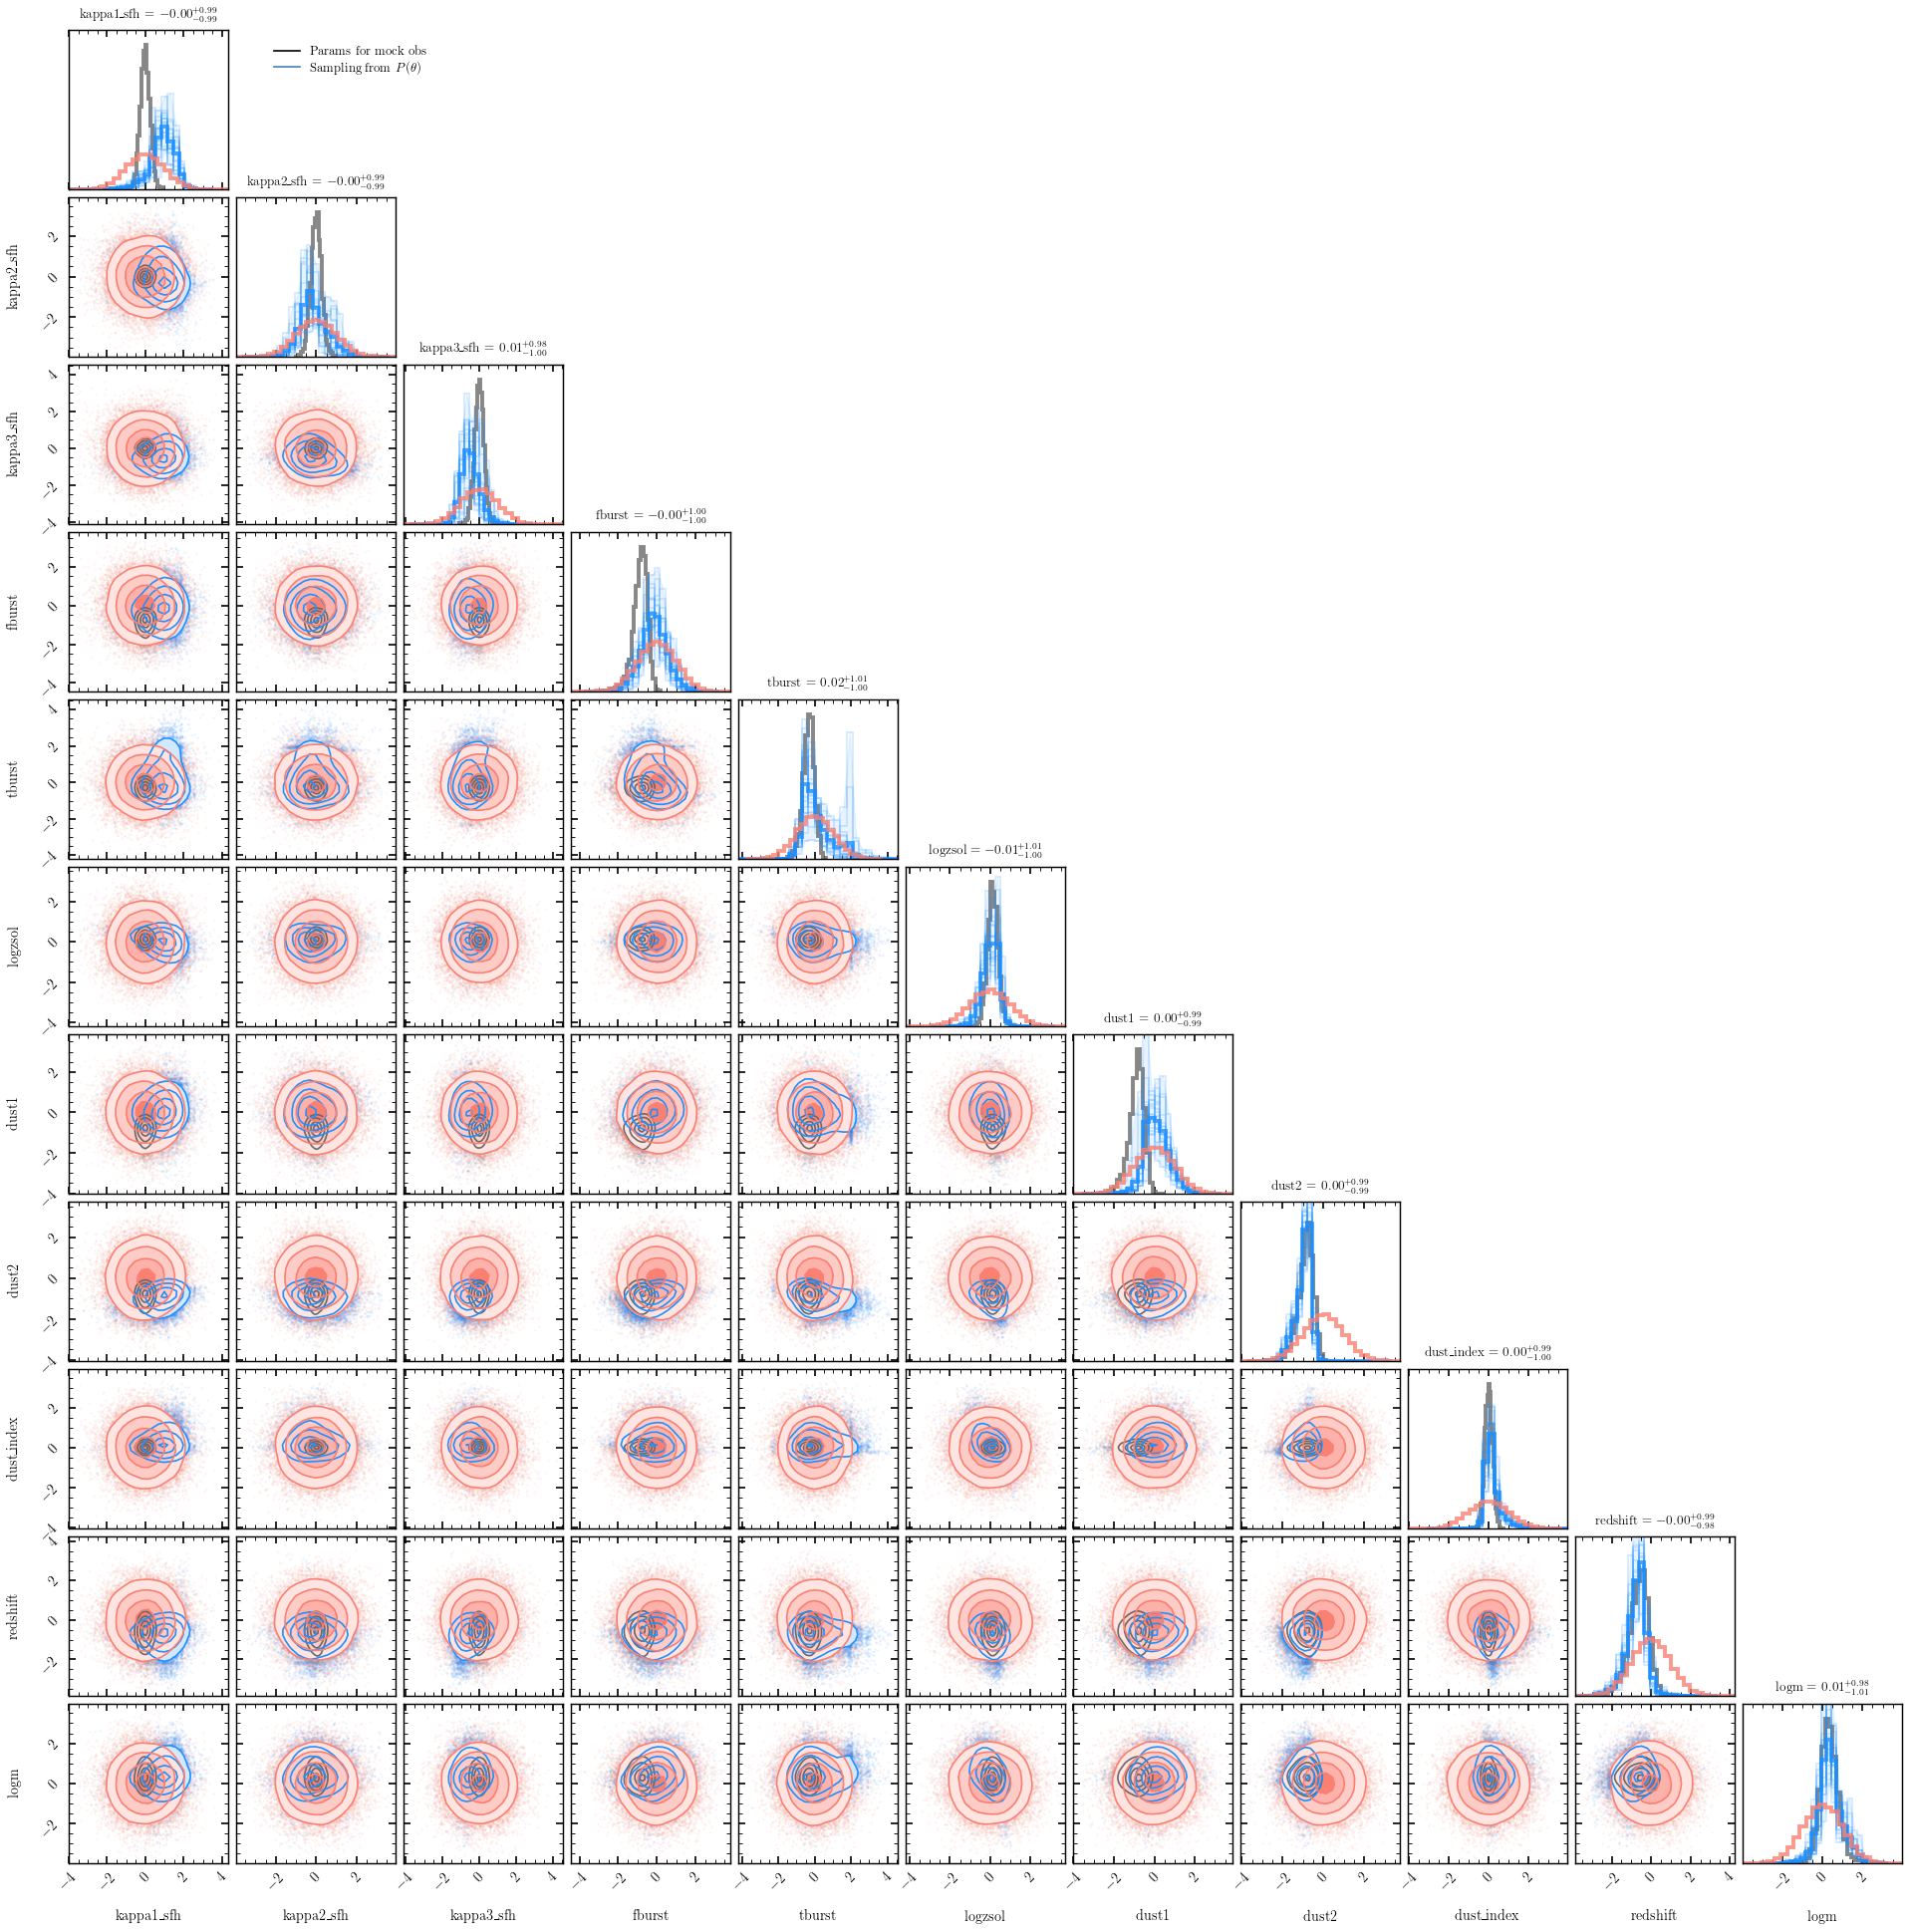

In [36]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Sampling from $P(\theta)$')

labels = [key.replace('_', '\_') for key in speculator.params_name]

figure = corner.corner(transform_nmf_params(Y_truth, _prior_NDE).cpu().detach().numpy(), 
                       color='dimgray', labels=labels, bins=25,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=1, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

nf_plot = corner.corner(transform_nmf_params(torch.Tensor(_samples_unt).to('cuda'), _prior_NDE
                                            ).cpu().detach().numpy(), 
                  fig=figure, labels=labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=1, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

_ = corner.corner(_init_sample, 
                   fig=figure, color='salmon', alpha=0.1, labels=labels, bins=25,
                   #quantiles=[0.16, 0.5, 0.84], 
                   smooth=0.8, fill_contours=True,
                   show_titles=True, 
                   hist_kwargs={'density': True, 'lw': 0.5}, 
                   title_kwargs={"fontsize": 12},
                   plot_datapoints=True)

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))